# The Art of Optimization: Finding the Needle in the Haystack

This is my favourite subtopic by far. I was tempted to put it with the first backtest notebook, but this just seems too special to me.

A single backtest is like one data point—interesting, but it's not the whole story. To *really* understand our strategy, we need to stress-test it against all the parameters we can think of. This is **optimization**, and it's where the magic happens.

A word of warning: this process can be resource-intensive and annoying as hell. That's why I'll try my best to make the code clear and efficient.

In [ ]:
%pip install backtesting pandas numpy yfinance matplotlib seaborn

### The Strategy

We'll use the same `QuantileStrategy` concept as before.

In [ ]:
import math
import pandas as pd
from backtesting import Strategy

class QuantileStrategy(Strategy):
    h_percentile = None  # Take Profit quantile
    l_percentile = None  # Stop Loss quantile
    mode = "long"        # "long" or "short"

    @staticmethod
    def default_func(series: pd.Series, q: float) -> pd.Series:
        """Expanding quantile of a series."""
        return series.expanding(min_periods=10).quantile(q)

    func = default_func

    def init(self):
        self.mode_coef = 1 if self.mode == "long" else -1
        self.mode_trade = self.buy if self.mode == "long" else self.sell

        o, h, l = self.data.Open, self.data.High, self.data.Low

        # Relative intrabar moves, shifted to avoid lookahead bias
        h_move = pd.Series((h - o) / o).shift(1)
        l_move = pd.Series((o - l) / o).shift(1)

        # Dynamic thresholds
        self.h_threshold = self.I(self.func, h_move, self.h_percentile) if self.h_percentile else None
        self.l_threshold = self.I(self.func, l_move, self.l_percentile) if self.l_percentile else None

    def next(self):
        if len(self.data) < 10:
            return

        price = self.data.Close[-1]
        h, l = self.h_threshold[-1], self.l_threshold[-1]

        if pd.isna(h) and pd.isna(l):
            return

        # If a percentile is None, set TP/SL to infinity
        tp = price * (1 + h * self.mode_coef) if h is not None else math.inf * self.mode_coef
        sl = price * (1 - l * self.mode_coef) if l is not None else -math.inf * self.mode_coef

        if self.position:
            self.position.close()

        # Sanity check: don't enter a trade if price is already outside SL/TP
        if sl * self.mode_coef < price * self.mode_coef < tp * self.mode_coef:
            self.mode_trade(
                tp=None if math.isinf(tp) else tp,
                sl=None if math.isinf(sl) else sl,
                size=1,
            )

### The Main Event: The Optimization Run

Now for the fun part. We'll define a range of percentiles for both our Take Profit (`h_percentile`) and Stop Loss (`l_percentile`). Then, we unleash `backtesting.py`'s `optimize` function to do the heavy lifting. It will run a backtest for every single combination and return a 'heatmap' of the results, showing us which parameters produced the best (or worst) 'Win Rate [%]'.

In [ ]:
import numpy as np
import yfinance as yf
from backtesting import Backtest

# Let's grab some data for Gold again.
tickers = ["GC=F"]
period = "1mo"
interval = "1h"

# --- Optimization Parameters ---
mode = "long"
column_to_maximize = "Win Rate [%]"
resolution = 10 # How many steps to test between 0 and 1
percentiles = list(np.round(np.linspace(0.01, 1, resolution), 2))

print("Fetching data for the grand experiment...")
data = yf.download(tickers=tickers, period=period, interval=interval, multi_level_index=False)

# Initialize the backtest environment.
bt = Backtest(data, QuantileStrategy, cash=10000, finalize_trades=True)

# Run the optimization!
stats, heatmap = bt.optimize(
    mode=mode,
    h_percentile=percentiles,
    l_percentile=percentiles,
    maximize=column_to_maximize,
    return_heatmap=True
)

print("\nOptimization Complete! Here's a look at the raw heatmap data:")
heatmap

Fetching data for the grand experiment...


/tmp/ipykernel_9927/1721787911.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=tickers, period=period, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed



Optimization Complete! Here's a look at the raw heatmap data:


mode  h_percentile  l_percentile
long  0.01          0.01            14.285714
                    0.12            14.285714
                    0.23            21.428571
                    0.34            28.571429
                    0.45            50.000000
                                      ...    
      1.00          0.56            37.449393
                    0.67            40.973631
                    0.78            45.030426
                    0.89            47.464503
                    1.00            49.695740
Name: Win Rate [%], Length: 100, dtype: float64

### Reverse-Engineering the Results

This heatmap data maps every parameter combination to a specific result. This is powerful because we can work backwards. Instead of asking 'What's the best win rate?', we can ask, 'If I want a ~46% win rate, what are all the parameter combinations that can get me there?'.

Let's write a quick script to find out.

In [41]:
import numpy as np

# Set our target value
target_value = 46
tolerance = 1 # How close to the target is acceptable (e.g., +/- 1%)

# Find all parameter sets that match our target
matches = []
for params, result_value in heatmap.items():
    mode, h, l = params  # unpack the parameters
    if np.isclose(result_value, target_value, atol=tolerance):
        matches.append((mode, h, l, result_value))

# Print the results nicely
if matches:
    print(f"Found matching parameters for a Win Rate of ~{target_value}%")
    for mode, h, l, wr in matches:
        print(f"  - mode: {mode}, h_percentile: {h}, l_percentile: {l}, Win Rate: {wr:.2f}%")
else:
    print(f"No matches found for a Win Rate of ~{target_value}%")

Found matching parameters for a Win Rate of ~46%
  - mode: long, h_percentile: 0.23, l_percentile: 0.56, Win Rate: 45.14%
  - mode: long, h_percentile: 0.45, l_percentile: 0.67, Win Rate: 45.84%
  - mode: long, h_percentile: 0.78, l_percentile: 0.78, Win Rate: 45.23%
  - mode: long, h_percentile: 1.0, l_percentile: 0.78, Win Rate: 45.03%


### A Picture is Worth a Thousand Backtests

As cool as that was, a list of numbers doesn't really help us see the *pattern*. For that, we need an actual picture. Let's visualize the heatmap with `matplotlib` and `seaborn` to see how the Take Profit and Stop Loss percentiles interact.

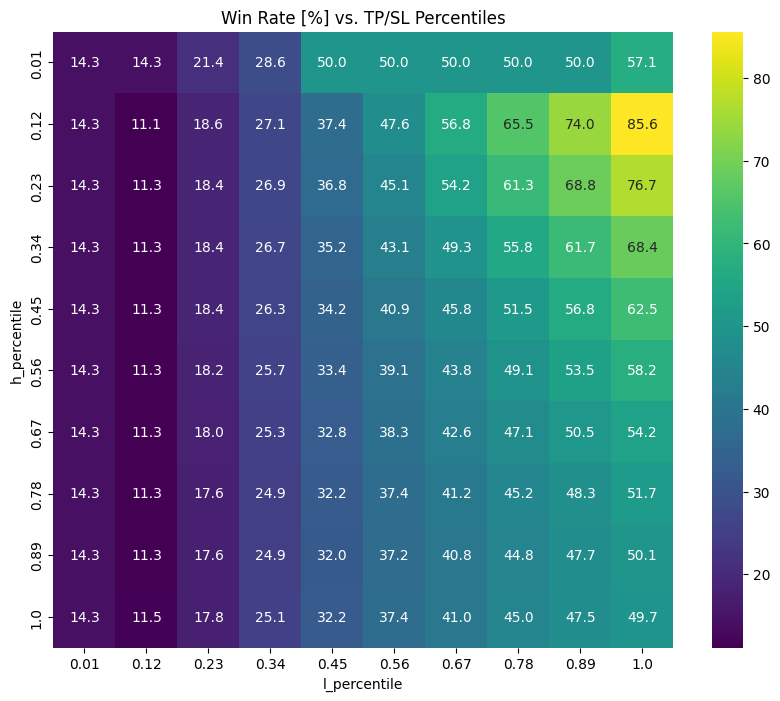

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the data into a 2D grid for plotting
heatmap_grid = heatmap.reset_index().pivot(
    index='h_percentile', 
    columns='l_percentile', 
    values=heatmap.name
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_grid, cmap='viridis', annot=True, fmt=".1f")
plt.title('Win Rate [%] vs. TP/SL Percentiles')
plt.show()

### Final Observation: A Hint of Thermodynamics?

Now, *this* is an interesting picture. The visualization shows a clear structure and relationship between the parameters and the outcome. 

As we increase the resolution of the test, this picture starts to look less like random noise and more like a heat transfer map on a 2D plane. We can see 'hot zones' of high win rates and 'cold zones' of low ones, with smooth gradients in between.

Is this just a coincidence for this specific market and timeframe, or does it hint at a general correlation with thermodynamics and market dynamics? I have an educated hunch it's the latter.